# Open-Full-Jaw
This notebook explains the steps of the pipeline used for generating the Open-Full-Jaw Dataset's meshes and simulation files.

# Imports

In [1]:
import os
import igl
import sys
import time
import glob
import json
import math
import pymesh
import meshio

import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.sparse.linalg import spsolve  # for solving the smoothing matrix(in the laplace_beltrami_smoothing function)


path_ftetwild = '/home/torkan/fTetWild/build/FloatTetwild_bin'
cargen_path   = './OpenFullJaw/other_libs/'

In [2]:
import sys
# sys.path.append('/home/torkan/diku_codes/Torkan/CarGen-main')
sys.path.append(cargen_path)
import cargen

sys.path.append('./')
import OpenFullJaw
from OpenFullJaw.utils import *

In [3]:
"""
DIRECTORIES:

main_dir:  the directory where this python file is located 

i_dir:      the folder where the original teeth and bone files are located
o_dir:      the output folder where all the final results are saved at
mid_o_dir:  the mid-output path where some inbetween files are stored

"""
# main directories
main_dir    = '../dataset/Patient_26'
p_id = main_dir.split('_')[-1]
main_dir = os.path.abspath(main_dir) # convert the relative path to an absolute path to make it to easy to work with


verbose  = True
# jaw_type = 'mandible'
jaw_type = 'maxilla'
params_log_info = {}     

os.chdir(main_dir)
# from isl.util.timer import Timer

# input and output paths
i_dir      = main_dir + '/' + 'input'       + '/' + jaw_type + '/'
o_dir      = main_dir + '/' + 'output'      + '/' + jaw_type + '/'
mid_o_dir  = main_dir + '/' + 'mid-output'  + '/' + jaw_type + '/'
o_surf_dir = o_dir    + 'surface_meshes'    + '/'
o_vol_dir  = o_dir    + 'volumetric_meshes' + '/'
o_sim_dir  = o_dir    + 'simulation'        + '/'

mid_o_isdir  = os.path.isdir( mid_o_dir ) 
o_isdir      = os.path.isdir( o_dir ) 
o_surf_isdir = os.path.isdir(o_surf_dir) 
o_vol_isdir  = os.path.isdir(o_vol_dir) 
o_sim_isdir  = os.path.isdir(o_sim_dir) 
teeth_dir = i_dir + 'teeth' + '/'
bone_dir  = i_dir + 'bone'  + '/'


# create the directories if they are not exist
if not mid_o_isdir:
    os.makedirs( mid_o_dir )
    print ( "created folder : ", mid_o_dir )
    
if not o_isdir:
    os.makedirs( o_dir )
    print ( "created folder : ", o_dir )
    
if not o_surf_isdir:
    os.makedirs( o_surf_dir )
    print ( "created folder : ", o_surf_dir )

if not o_vol_isdir:
    os.makedirs( o_vol_dir )
    print ( "created folder : ", o_vol_dir )   

if not o_sim_isdir:
    os.makedirs( o_sim_dir )
    print ( "created folder : ", o_sim_dir )
    

mid_o_glued_dir = mid_o_dir + 'glued' + '/'
mid_o_teeth_dir = mid_o_dir + 'teeth' + '/'
mid_o_bone_dir  = mid_o_dir + 'bone'  + '/' 
mid_o_pdl_dir   = mid_o_dir + 'pdl'   + '/'

mid_o_glued_isdir = os.path.isdir(mid_o_glued_dir) 
mid_o_teeth_isdir = os.path.isdir(mid_o_teeth_dir) 
mid_o_bone_isdir  = os.path.isdir(mid_o_bone_dir) 
mid_o_pdl_isdir   = os.path.isdir(mid_o_pdl_dir) 



if not mid_o_glued_isdir:
    os.makedirs( mid_o_glued_dir )
    print ( "created folder : ", mid_o_glued_dir )
    
if not mid_o_teeth_isdir:
    os.makedirs( mid_o_teeth_dir )
    print ( "created folder : ", mid_o_teeth_dir )

if not mid_o_bone_isdir:
    os.makedirs( mid_o_bone_dir )
    print ( "created folder : ", mid_o_bone_dir )   

if not mid_o_pdl_isdir:
    os.makedirs( mid_o_pdl_dir )
    print ( "created folder : ", mid_o_pdl_dir )
    

## 1.Preprocessing step

### 1.1. Remesh and reduce the bone mesh

In [4]:
path_bone = bone_dir + jaw_type + '.stl'

params = Params()
params.max_iter = 1
params.ftet_path = path_ftetwild

#---- remesh the bone mesh
params.output_fname = 'bone_remeshed'
params.output_dir   = mid_o_bone_dir
v_b, f_b = OpenFullJaw.preprocess_bone(path_bone, params)

Meshing time(s):  193.93


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.688248…

bone remeshing time (s):  195.39


### 1.2. Smooth the bone

In [5]:
# smooth the bone to remove spikes on cervical regions
v_b, f_b = igl.read_triangle_mesh(mid_o_bone_dir + 'bone_remeshed.obj')

params.output_fname = 'bone_remeshed_smoothed'
params.output_dir = mid_o_bone_dir
v_b_new, f_b = OpenFullJaw.smooth_bone(v_b, f_b, params)

---- original mesh superimposed on smoothed mesh


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.690153…

---- modified regions with highlighted points


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.690153…

bone smoothing time (s):  8.49
{'smoothing_iteration': 10, 'smoothing_stp_size': 0.0005, 'min distance': 1.8572877072742525e-08, 'max distance': 0.13351377998220837, 'bone_smoothing_time': 8.49}


##  2. Gap generation

### 2.1. Check the offset limit of the bone and shrink the bone

In [6]:
params.output_fname = 'bone_temp'
params.output_dir = mid_o_bone_dir

v_b_shrinked, f_b, bone_offset, shrinking_info = OpenFullJaw.shrink_bone(v_b_new, f_b, params)

---- the offset limit of the bone is:  0.06899863477036984
---- will assume its offset limit is {} to avoid paper thin walls in the bone mesh.  0.04
bone offset limit(0.04) is less than desired gap (0.1).
is shrinking the bone with 0.04 mm.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.690155…

### 2.2. Shrink the teeth

#### Read and shrink the teeth one by one

In [7]:
params.output_fname = 'all_teeth_shrinked'
params.output_dir = mid_o_teeth_dir
rest = params.gap_thickness - bone_offset

teeth_v, teeth_f, unn, centers, impacted = OpenFullJaw.shrink_teeth(teeth_dir, rest, shrinking_info, params)


is shrinking the teeth with 0.16 mm.
--------------------------------------------- tooth_1
number of triangles 32948
reading time: 0.01
cleaning time: 1.72


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(30.756266…

num_vertices of original tooth :  16476
num_vertices of shrinked tooth :  62014
-----------------------------------------------
--------------------------------------------- tooth_10
number of triangles 26624
reading time: 0.01
cleaning time: 1.14


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.439666…

num_vertices of original tooth :  13314
num_vertices of shrinked tooth :  49234
-----------------------------------------------
--------------------------------------------- tooth_11
number of triangles 27608
reading time: 0.01
cleaning time: 1.24


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(69.027606…

num_vertices of original tooth :  13806
num_vertices of shrinked tooth :  51406
-----------------------------------------------
--------------------------------------------- tooth_12
number of triangles 27616
reading time: 0.01
cleaning time: 1.23


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.248394…

num_vertices of original tooth :  13810
num_vertices of shrinked tooth :  51128
-----------------------------------------------
--------------------------------------------- tooth_13
number of triangles 25296
reading time: 0.01
cleaning time: 1.05


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.946937…

num_vertices of original tooth :  12650
num_vertices of shrinked tooth :  46736
-----------------------------------------------
--------------------------------------------- tooth_14
number of triangles 36700
reading time: 0.01
cleaning time: 2.17


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.972957…

num_vertices of original tooth :  18352
num_vertices of shrinked tooth :  68836
-----------------------------------------------
--------------------------------------------- tooth_15
number of triangles 32044
reading time: 0.01
cleaning time: 1.66


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(76.156879…

num_vertices of original tooth :  16024
num_vertices of shrinked tooth :  59264
-----------------------------------------------
--------------------------------------------- tooth_2
number of triangles 36044
reading time: 0.01
cleaning time: 2.33


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.583264…

num_vertices of original tooth :  18024
num_vertices of shrinked tooth :  67886
-----------------------------------------------
--------------------------------------------- tooth_3
number of triangles 40272
reading time: 0.01
cleaning time: 2.54


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.922069…

num_vertices of original tooth :  20138
num_vertices of shrinked tooth :  74896
-----------------------------------------------
--------------------------------------------- tooth_4
number of triangles 25536
reading time: 0.01
cleaning time: 1.15


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.713967…

num_vertices of original tooth :  12770
num_vertices of shrinked tooth :  47076
-----------------------------------------------
--------------------------------------------- tooth_5
number of triangles 23968
reading time: 0.01
cleaning time: 0.98


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.471040…

num_vertices of original tooth :  11986
num_vertices of shrinked tooth :  44246
-----------------------------------------------
--------------------------------------------- tooth_6
number of triangles 28896
reading time: 0.01
cleaning time: 1.37


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(40.875490…

num_vertices of original tooth :  14450
num_vertices of shrinked tooth :  53706
-----------------------------------------------
--------------------------------------------- tooth_7
number of triangles 26272
reading time: 0.01
cleaning time: 1.15


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.386672…

num_vertices of original tooth :  13138
num_vertices of shrinked tooth :  48388
-----------------------------------------------
--------------------------------------------- tooth_8
number of triangles 28508
reading time: 0.01
cleaning time: 1.36


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.345796…

num_vertices of original tooth :  14256
num_vertices of shrinked tooth :  52972
-----------------------------------------------
--------------------------------------------- tooth_9
number of triangles 29124
reading time: 0.01
cleaning time: 1.43


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.305356…

num_vertices of original tooth :  14564
num_vertices of shrinked tooth :  54180
-----------------------------------------------


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.084893…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.084462…

Time for shrinking all teeth with voxel of 0.1 (s):  164.24


### 1.3. Remesh and reduce the teeth meshes

In [8]:
### 1.3. Remesh and reduce the eroded teeth meshes

tooth_file  =  "all_teeth_shrinked.obj"
path_all_teeth = mid_o_teeth_dir + tooth_file


params.output_fname = 'teeth_remeshed'
params.output_dir   = mid_o_teeth_dir

V_ts, F_ts = OpenFullJaw.remesh_teeth(path_all_teeth, params)

OpenFullJaw.split_teeth_to_separate_meshes(V_ts, F_ts, centers, unn, params)

Meshing time(s):  302.47
teeth remeshing time (s):  303.78


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(30.755899…

## 3. PDL rim generation

### 3.1. Generate PDL rim for each tooth

number of triangles after cleaning 255232
bone cleanup time (s):  16.23
generating PDL top for Tooth_1
number of triangles after cleaning 16244


/home/torkan/diku_codes/Torkan/Open-Full-Jaw/src/OpenFullJaw/step3_pdl_rim_generation.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i in impacted:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(30.755899…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(30.755899…

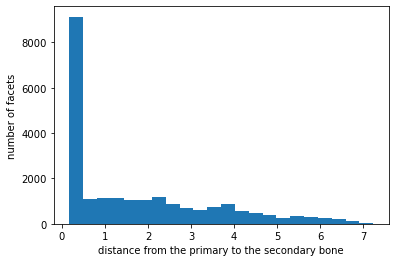

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

Base layer: max dihedral angle before smoothing is  0.32 radians ( 18.33 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

Base layer: max dihedral angle after smoothing is  3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

Quality control results for the base layer: 

- There are issues with these vertex indices [24, 25, 26, 27, 56, 57, 58, 71, 72, 73]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  4
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

Extruded layer: max dihedral angle before smoothing is  3.12 radians ( 178.76 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.433702…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.433702…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [24, 25, 26, 27, 56, 57, 58, 71, 72, 73]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.433702…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.433702…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.433702…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.433702…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(30.814628…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.292327…

pdl base area is:  202.58
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.24
PDL generation time (s):  14.18
generating PDL top for Tooth_10
number of triangles after cleaning 11822


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.438899…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.438899…

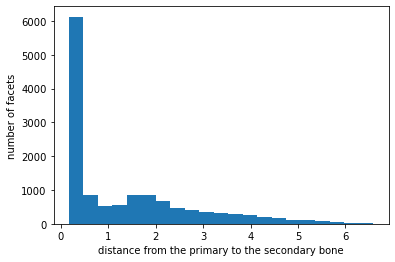

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

Base layer: max dihedral angle before smoothing is  0.33 radians ( 18.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

Quality control results for the base layer: 

- There are issues with these vertex indices [34, 35, 36, 37, 74, 75, 76, 77, 78, 79]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  2
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

Extruded layer: max dihedral angle before smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(63.976831…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(63.976831…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [34, 35, 36, 37, 74, 75, 76, 77, 79, 81, 82]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(63.976831…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(63.976831…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(63.976831…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(63.976831…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(64.684761…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(65.336189…

pdl base area is:  157.69
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  12.73
generating PDL top for Tooth_11
number of triangles after cleaning 11602


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(69.027748…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(69.027748…

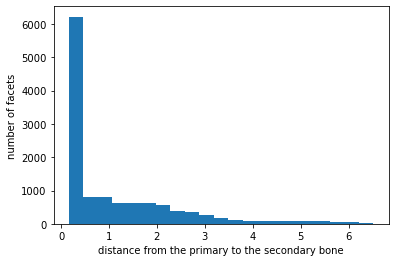

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

Base layer: max dihedral angle before smoothing is  0.34 radians ( 19.48 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

Quality control results for the base layer: 

- There are issues with these vertex indices [5, 6, 7, 8]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  11
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

Extruded layer: max dihedral angle before smoothing is  3.09 radians ( 177.04 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.483184…

Extruded layer: max dihedral angle after smoothing is 3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.483184…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [5, 6, 7, 8]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.483184…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.483184…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.483184…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.483184…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.730041…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(68.916770…

pdl base area is:  170.64
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  10.85
generating PDL top for Tooth_12
number of triangles after cleaning 13300


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.248199…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.248199…

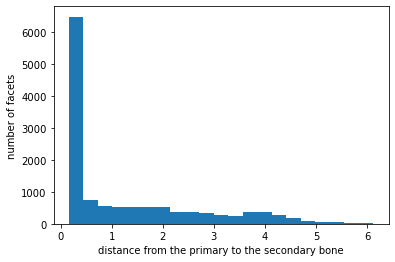

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.121559…

Base layer: max dihedral angle before smoothing is  0.46 radians ( 26.36 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.121559…

Base layer: max dihedral angle after smoothing is  0.49 radians ( 28.07 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.121559…

Quality control results for the base layer: 

Everything is clean in the base layer. we will now continue to extrusion step:

Extruded layer: max dihedral angle before smoothing is  0.67 radians ( 38.39 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.884693…

Extruded layer: max dihedral angle after smoothing is 2.69 radians ( 154.13 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.884693…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [87, 88]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  4
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.884693…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.884693…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.884693…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.121559…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.884693…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(70.848060…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.121559…

pdl base area is:  168.5
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.21
PDL generation time (s):  11.63
generating PDL top for Tooth_13
number of triangles after cleaning 11568


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.946147…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.946147…

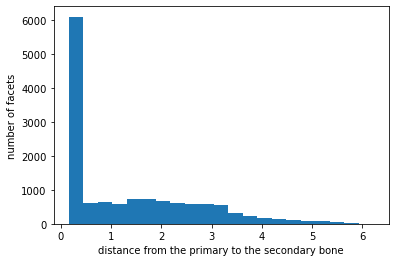

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

Base layer: max dihedral angle before smoothing is  0.45 radians ( 25.78 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

Base layer: max dihedral angle after smoothing is  2.7 radians ( 154.7 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

Quality control results for the base layer: 

- There are issues with these vertex indices [59, 60, 61]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  13
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

Extruded layer: max dihedral angle before smoothing is  3.12 radians ( 178.76 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.428668…

Extruded layer: max dihedral angle after smoothing is 3.12 radians ( 178.76 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.428668…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [59, 60, 61]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.428668…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.428668…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.428668…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.428668…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(73.541934…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.005764…

pdl base area is:  159.42
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.21
PDL generation time (s):  12.41
generating PDL top for Tooth_14
number of triangles after cleaning 16730


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.972949…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.972949…

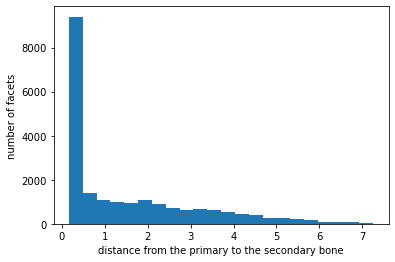

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

Base layer: max dihedral angle before smoothing is  0.36 radians ( 20.63 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

Quality control results for the base layer: 

- There are issues with these vertex indices [91, 92, 93, 106, 107, 109, 110, 111]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  4
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

Extruded layer: max dihedral angle before smoothing is  3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.395317…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.395317…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [63, 64, 65, 88, 89, 91, 93, 94, 106, 107, 109, 110, 111]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.395317…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.395317…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.395317…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.395317…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(74.645706…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.025032…

pdl base area is:  224.14
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.28
PDL generation time (s):  13.75
generating PDL top for Tooth_15
number of triangles after cleaning 17120


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(76.156349…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(76.156349…

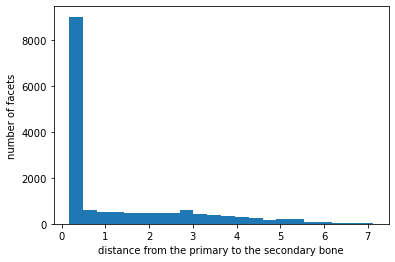

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

Base layer: max dihedral angle before smoothing is  0.44 radians ( 25.21 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

Quality control results for the base layer: 

- There are issues with these vertex indices [92, 93, 94, 95, 96]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  8
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

Extruded layer: max dihedral angle before smoothing is  3.11 radians ( 178.19 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.235855…

Extruded layer: max dihedral angle after smoothing is 3.12 radians ( 178.76 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.235855…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [93, 94, 95, 96]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.235855…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.235855…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.235855…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.235855…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.533451…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(75.790729…

pdl base area is:  191.04
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  17.47
generating PDL top for Tooth_2
number of triangles after cleaning 15572


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.582850…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.582850…

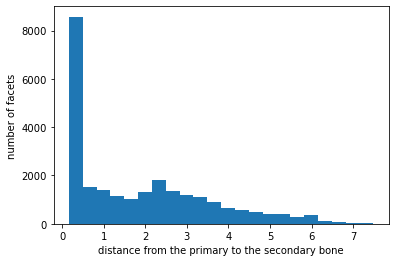

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

Base layer: max dihedral angle before smoothing is  0.35 radians ( 20.05 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

Quality control results for the base layer: 

- There are issues with these vertex indices [22, 23, 24, 25]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  9
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

Extruded layer: max dihedral angle before smoothing is  0.35 radians ( 20.05 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.082258…

Extruded layer: max dihedral angle after smoothing is 3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.082258…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [22, 23, 24, 25, 104, 105, 106, 107]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  0
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.082258…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.082258…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.082258…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.082258…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.000448…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(31.666181…

pdl base area is:  232.54
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  14.28
generating PDL top for Tooth_3
number of triangles after cleaning 20180


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.922049…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.922049…

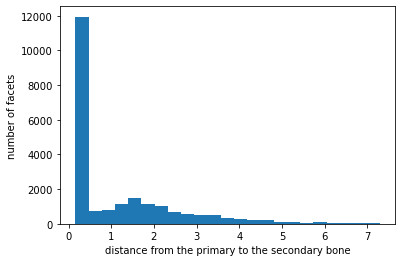

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

Base layer: max dihedral angle before smoothing is  0.45 radians ( 25.78 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

Base layer: max dihedral angle after smoothing is  3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

Quality control results for the base layer: 

- There are issues with these vertex indices [41, 42, 43, 57, 58, 59, 60]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  10
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

Extruded layer: max dihedral angle before smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.387075…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.387075…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [41, 42, 43, 57, 58, 59, 60, 86, 87, 88]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.387075…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.387075…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.387075…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.387075…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.105965…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(32.837010…

pdl base area is:  258.95
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.26
PDL generation time (s):  16.4
generating PDL top for Tooth_4
number of triangles after cleaning 11850


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.714250…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.714250…

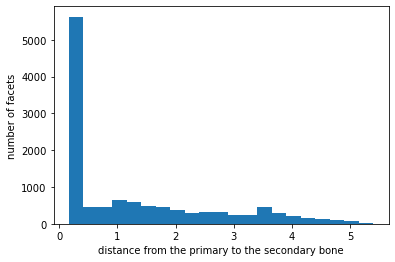

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

Base layer: max dihedral angle before smoothing is  0.49 radians ( 28.07 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

Quality control results for the base layer: 

- There are issues with these vertex indices [69, 70, 71]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  4
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

Extruded layer: max dihedral angle before smoothing is  3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.806110…

Extruded layer: max dihedral angle after smoothing is 3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.806110…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [28, 29, 30, 69, 70, 71]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.806110…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.806110…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.806110…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.806110…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.819725…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(35.690294…

pdl base area is:  149.05
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  11.19
generating PDL top for Tooth_5
number of triangles after cleaning 11948


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.471050…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.471050…

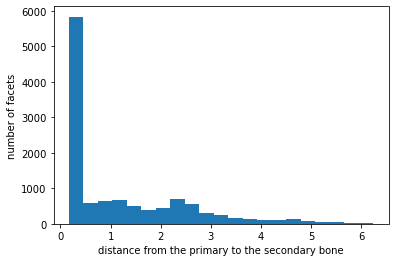

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.487012…

Base layer: max dihedral angle before smoothing is  0.46 radians ( 26.36 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.487012…

Base layer: max dihedral angle after smoothing is  0.44 radians ( 25.21 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.487012…

Quality control results for the base layer: 

Everything is clean in the base layer. we will now continue to extrusion step:

Extruded layer: max dihedral angle before smoothing is  0.47 radians ( 26.93 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.873620…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.873620…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [3, 4, 5, 21, 22, 24]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  2
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.873620…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.873620…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.873620…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.487012…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.873620…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.840515…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.487012…

pdl base area is:  134.73
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  10.23
generating PDL top for Tooth_6
number of triangles after cleaning 12164


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(40.876550…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(40.876550…

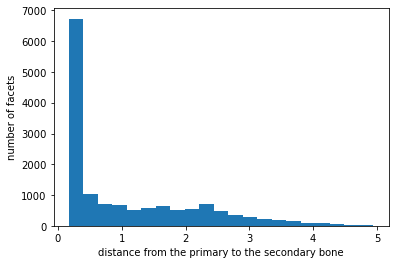

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

Base layer: max dihedral angle before smoothing is  0.43 radians ( 24.64 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

Quality control results for the base layer: 

- There are issues with these vertex indices [61, 62, 64, 65, 77, 78, 80, 81]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  3
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

Extruded layer: max dihedral angle before smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.528564…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.528564…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [60, 61, 62, 64, 65, 66, 77, 78, 80, 81, 82, 83]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.528564…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.528564…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.528564…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.528564…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.377281…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(41.397497…

pdl base area is:  189.46
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.25
PDL generation time (s):  13.83
generating PDL top for Tooth_7
number of triangles after cleaning 11468


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.385999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.385999…

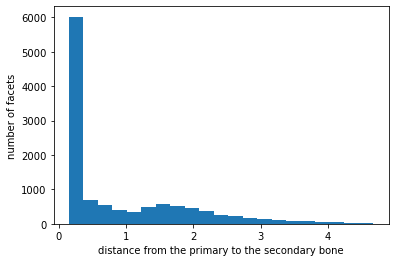

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

Base layer: max dihedral angle before smoothing is  0.41 radians ( 23.49 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

Base layer: max dihedral angle after smoothing is  3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

Quality control results for the base layer: 

- There are issues with these vertex indices [39, 40, 41, 42]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  7
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

Extruded layer: max dihedral angle before smoothing is  0.41 radians ( 23.49 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(46.160367…

Extruded layer: max dihedral angle after smoothing is 3.13 radians ( 179.34 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(46.160367…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [39, 40, 41, 42, 56, 57, 58]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(46.160367…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(46.160367…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(46.160367…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(46.160367…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.883127…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(45.437915…

pdl base area is:  158.69
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.22
PDL generation time (s):  11.37
generating PDL top for Tooth_8
number of triangles after cleaning 12052


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.346549…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.346549…

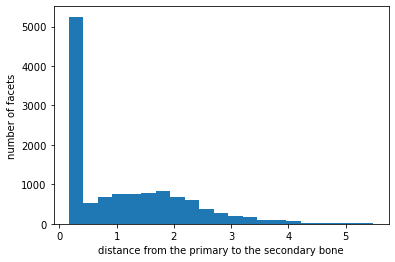

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

Base layer: max dihedral angle before smoothing is  0.36 radians ( 20.63 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

Base layer: max dihedral angle after smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

Quality control results for the base layer: 

- There are issues with these vertex indices [4, 5, 6, 57, 58, 59, 60]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  7
- Solution 2: By default the faulty triangles will be removed from the face index list 

faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

Extruded layer: max dihedral angle before smoothing is  3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.861776…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.861776…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [3, 4, 5, 6, 57, 58, 59, 60]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  -1
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.861776…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.861776…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.861776…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.861776…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(51.743841…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.229814…

pdl base area is:  141.27
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.21
PDL generation time (s):  11.24
generating PDL top for Tooth_9
number of triangles after cleaning 12572


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.305849…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.305849…

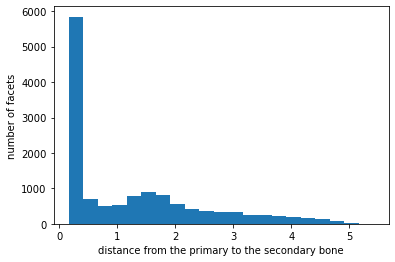

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.256357…

Base layer: max dihedral angle before smoothing is  0.32 radians ( 18.33 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.256357…

Base layer: max dihedral angle after smoothing is  0.42 radians ( 24.06 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.256357…

Quality control results for the base layer: 

Everything is clean in the base layer. we will now continue to extrusion step:

Extruded layer: max dihedral angle before smoothing is  0.35 radians ( 20.05 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.234657…

Extruded layer: max dihedral angle after smoothing is 3.14 radians ( 179.91 degrees).


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.234657…

Quality control results  for the extruded layer: 

- There are issues with these vertex indices [3, 4, 5, 53, 54]
- Solution 1: To prevent this issue, decrease your 'param.smoothing_iteration' to  4
- Solution 2: By default the faulty triangles will be removed from the face index list 
faulty vertices & neighbouring triangles:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.234657…

The pink triangles will be removed:
No.........................


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.234657…

normal visualization of the fixed result:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.234657…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.256357…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.234657…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(59.136093…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(60.256357…

pdl base area is:  160.41
mean pdl thickness is:  0.2
maximum pdl thickness is:  0.21
PDL generation time (s):  12.39
PDL generation time (s):  234.02


In [9]:
# these two parameters were the same across all patients models. Note that, changing these values can extremly affect the hight of the PDL geometries. 
# params.rim_thickness_factor     =  1
# params.rim_trim_iter            =  2

# the following parameters are the ones that can be adjusted based on the patient-specific geometries.
params.rim_distance_rest        =  0.26
params.rim_distance_molars      =  0.28  #0.3
params.rim_smooth_iter_base     =  16    #8 #10
params.rim_smooth_iter_extruded_base  = 10  #5 #7


cargen_bone_input = mid_o_bone_dir + "bone_temp.obj"
params.input_dir     =  mid_o_teeth_dir
params.input_fname   =  'tooth_{}_temp.obj' # Note that the file name should include a {}, as the {} will be replaced by tooth unn number in the following funtion, e.g., tooth_18_temp.obj
params.output_fname  =  'pdl_{}_top.obj' # Note that the file name should include a {}, as the {} will be replaced by pdl's unn number in the following funtion, e.g., pdl_18_top.obj corresponds to the pdl rim associated with tooth 18.
params.output_dir    =  mid_o_pdl_dir

OpenFullJaw.generate_pdls_rims(cargen_bone_input, mid_o_teeth_dir, unn, impacted, params)

### 3.2. Combine all PDL rims 

In [10]:
# unn = np.load(mid_o_dir + 'unn.npy')
# centers = np.load(mid_o_dir + 'centers.npy')
# impacted = np.load(mid_o_dir + 'impacted_teeth.npy')

In [11]:
#----------------------------------------------------- Merge all pdl tops

firt_time = True
# unn = np.load ( mid_o_dir + "unn.npy" )

for i in unn:
    
    if i in impacted:
        continue
        
    v, f = igl.read_triangle_mesh( mid_o_pdl_dir + "pdl_{}_top.obj".format(i) )    
        
    if firt_time:
        pdls_v = v
        pdls_f = f
        firt_time = False      
    else: 
        pdls_v, pdls_f = merge_surface_mesh ( pdls_v, pdls_f, v, f )
        
frame3 = mp.plot (pdls_v, pdls_f, c = pdl_c, shading = sh_false, return_plot = True)
igl.write_triangle_mesh ( mid_o_pdl_dir + "/all_pdls_tops.obj", pdls_v, pdls_f)

/home/torkan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.903276…

True

### 3.3. Make the PDL rim wider
This step is essential for the next step (the multi-domain volumetric mesh generation). This is to make sure that even with slight deviations from the input meshes, still the PDL rims can be used for proper filtering of the generated tetrahedrons.

In [12]:
sh_p_x = { "point_size": 0.5, "point_color": "red" }
sh_p_y = { "point_size": 0.55, "point_color": "green" }
sh_p_z = { "point_size": 0.5, "point_color": "blue" }

path_teeth = mid_o_teeth_dir + "all_teeth_temp.obj"   # includes the impacted teeth as well
path_pdl   = mid_o_pdl_dir   + "all_pdls_tops.obj"
path_bone  = mid_o_bone_dir  + "bone_temp.obj"

params.output_fname  =  'all_pdls_tops_wider.obj' 
params.output_dir    =  mid_o_pdl_dir

OpenFullJaw.make_pdl_rim_wider(path_teeth, path_pdl, path_bone, params)
    

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.903276…

Zoom-in on one of the PDL rims to see further details.
Red points   : the points that are in contact with the tooth.
Blue points  : the points that are in contact with the bone.
Green points : the points of the wider PDL rim to be used as the input of the multi-domain meshing process.


## 4. Multi-domain volumetric mesh generation (gluing the teeth, pdl rims, and bone)

### 4.1. Sanity check the bone mesh for patients with fully impacted teeth 
The preprocessing step on the bone eliminates the tooth socket for the fully-impacted teeth as meshing artifacts. Therefore, we need to add those teeth sockets to the bone geometry before the multi-domain meshing process.

In [13]:
path_bone   = mid_o_bone_dir + "bone_temp.obj"
v_b, f_b = igl.read_triangle_mesh(path_bone)

mesh_sanity_check(v_b, f_b, 2, 0.7, 'bone_temp')

for i in impacted:
    v, f = igl.read_triangle_mesh(teeth_dir + 'tooth_' + i + '_impacted.stl')
    f = flip_normals(f)
    v_b, f_b = merge_surface_mesh(v_b, f_b, v, f, 'bone_temp with the fully-impacted tooth socket')
if impacted.size != 0:
    mesh_sanity_check(v_b, f_b, 2,0.7)
    igl.write_triangle_mesh(mid_o_bone_dir + "bone_temp.obj", v_b, f_b)

----> sanitiy check of (bone_temp) mesh


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.690155…

### 4.2. Generate a volumetric mesh by gluing input surface meshes using a CSG operation

In [14]:
### 1. Go to the main directory
os.chdir(main_dir)

path_teeth = mid_o_teeth_dir + "all_teeth_temp.obj"
path_pdl   = mid_o_pdl_dir   + "all_pdls_tops_wider.obj"
path_bone  = mid_o_bone_dir  + "bone_temp.obj"
    
# update json path to a new directory
params.volume_mesh_json_path       =  mid_o_glued_dir + 'merge_meshes.json'
params.volume_mesh_operation_type  =  'union'

# change the mesh parameters to desired values
params.volume_mesh_eps  =  2e-4
params.volume_mesh_l    =  0.05    
params.max_iter         =  20
params.output_dir       =  mid_o_glued_dir  
params.output_fname     =  'output_mesh' 

### Generate unlabeled volumetric mesh that considers multi-domains and includes the background mesh
V, T, gluing_info = OpenFullJaw.generate_raw_mesh(path_teeth, path_pdl, path_bone, params)


{
    "operation": "union",
    "left": "/home/torkan/diku_codes/Torkan/Open-Full-Jaw/dataset/Patient_26/mid-output/maxilla/teeth/all_teeth_temp.obj",
    "right": {
        "operation": "union",
        "left": "/home/torkan/diku_codes/Torkan/Open-Full-Jaw/dataset/Patient_26/mid-output/maxilla/pdl/all_pdls_tops_wider.obj",
        "right": "/home/torkan/diku_codes/Torkan/Open-Full-Jaw/dataset/Patient_26/mid-output/maxilla/bone/bone_temp.obj"
    }
}
/home/torkan/diku_codes/Torkan/Open-Full-Jaw/dataset/Patient_26/mid-output/maxilla/glued/merge_meshes.json
output_path :  /home/torkan/diku_codes/Torkan/Open-Full-Jaw/dataset/Patient_26/mid-output/maxilla/glued/output_mesh_with_eps_0.0002_l_0.05
gluing time (s):  493.71


## 5. Tetrahedra filtering (tetrahedra labeling)
In this step, all tetrahedra of the "raw mesh" are labelled with their associated domain and the background tetrahedra are labeled with 0 to be filtered out from the volumetric mesh.  

In [16]:
### Label the whole volume w.r.t input meshes
t3 = time.time()
V_new, T_new, L = OpenFullJaw.label_raw_mesh(V, T, path_teeth, path_pdl, path_bone, params)

if impacted.size != 0: # fix the labeling for the impacted teeth
    _, L = OpenFullJaw.label_impacted_pdl(V_new, T_new, L, teeth_dir, mid_o_teeth_dir, impacted)

t4 = time.time()

### Save labeled mesh
save_vol_mesh(V_new, T_new, L, o_vol_dir + jaw_type + '_volumetric_mesh.msh')
print('saved the volume mesh at ', o_vol_dir + jaw_type + '_volumetric_mesh.msh')

label_time = np.round(t4 - t3, 2)
print("labeling time (s): ", label_time)

gluing_info ['labeling_time'] = label_time
params.params_log_info['gluing_parameters'] =  gluing_info

----> sanitiy check of (tooth) mesh


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.084100…

----> sanitiy check of (bone) mesh


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.690155…

----> sanitiy check of (pdl) mesh


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.901501…

----> step0: hollow of teeth


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> step0: hollow of bone


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> step0: hollow of bone, plane cut 


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> step1: intersection of hollow of teeth and the hollow of the bone


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> step0: hollow of bone, plane cut 


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> step2: positive winding numbers w.r.t. PDL rings


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> step3: intersection of step1 and step2


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> final result for PDL geometries


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

----> Pipeline input meshes:
Bone_temp, PDL_rims_wide, Teeth_temp


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.690155…

----> The labelled tetrahedra:
Bone, PDL, Teeth


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529715…

saved the volume mesh at  /home/torkan/diku_codes/Torkan/Open-Full-Jaw/dataset/Patient_26/output/maxilla/volumetric_meshes/maxilla_volumetric_mesh.msh
labeling time (s):  65.62


In [17]:
# unn = np.load(mid_o_dir + 'unn.npy')
# centers = np.load(mid_o_dir + 'centers.npy')
# impacted = np.load(mid_o_dir + 'impacted_teeth.npy')


## 6.Sanity check for PDL width and save final surface meshes.

In [18]:
# 1 Tooth
# 2 PDL
# 3 Bone
VV, TT, LL = read_vol_mesh(o_vol_dir + jaw_type + '_volumetric_mesh.msh')

v_t, f_t = extract_tri_mesh_from_vol_mesh(VV, TT[LL == 1])
v_p, f_p = extract_tri_mesh_from_vol_mesh(VV, TT[LL == 2])
v_b, f_b = extract_tri_mesh_from_vol_mesh(VV, TT[LL == 3])

sh_p_c = { "point_size": 5, "point_color": "gray" }
sh_p_x = { "point_size": 1, "point_color": "red" }
sh_p_y = { "point_size": 0.55, "point_color": "green" }
sh_p_z = { "point_size": 1, "point_color": "blue" }


v_t, f_t, _, _ = igl.remove_unreferenced(v_t, f_t)
v_p, f_p, _, _ = igl.remove_unreferenced(v_p, f_p)
v_b, f_b, _, _ = igl.remove_unreferenced(v_b, f_b)


igl.write_triangle_mesh(o_surf_dir + 'teeth.stl', v_t, f_t)
igl.write_triangle_mesh(o_surf_dir + 'pdls.stl', v_p, f_p)    
igl.write_triangle_mesh(o_surf_dir + 'bone.stl', v_b, f_b)

sd_value, _, closest_points = igl.signed_distance(v_p, v_b, f_b, return_normals=False)


idx_out = sd_value < 0.00000001

frame = mp.plot(v_p, f_p, shading = sh_true)
frame.add_points(v_p[idx_out], shading= sh_p_x)

thickness, _, closest_points = igl.signed_distance(v_p[idx_out], v_t, f_t, return_normals=False)



pdl_info = { 'min_thickness' : min(thickness),
             'max_thickness' : max(thickness),
             'avrg_thickness' : np.mean(thickness)
           }

print(pdl_info)
params.params_log_info['pdl_thickness_info'] = pdl_info  


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(52.910750…

{'min_thickness': 0.149718626684881, 'max_thickness': 0.2806919841596673, 'avrg_thickness': 0.19771032390092444}


In [19]:
params.params_log_info

{'bone_remeshing_parameters': {'epsilon': 0.0001,
  'edge_length': 0.02,
  'max_iterations': 1,
  'bone_remeshing_time': 195.39},
 'bone_smoothing_parameters': {'smoothing_iteration': 10,
  'smoothing_stp_size': 0.0005,
  'min distance': 1.8572877072742525e-08,
  'max distance': 0.13351377998220837,
  'bone_smoothing_time': 8.49},
 'shrinking_parameters': {'desired_gap': 0.2,
  'bone_ratio_for_gap': 0.5,
  'bone_offset_limit': 0.04,
  'bone_offset': 0.04,
  'comment': 'bone offset limit(0.04) is less than desired gap (0.1).',
  'teeth_offset': 0.16,
  'voxel_size': 0.1,
  'shrinking_time': 164.24},
 'teeth_remeshing_parameters': {'epsilon': 0.0001,
  'edge_length': 0.01,
  'max_iterations': 1,
  'bone_remeshing_time': 303.78},
 'PDL_generation_parameters': {'gap_distance': 0.26,
  'gap_distance_molars': 0.28,
  'thickness_factor': 1,
  'trimming_iteration': 2,
  'smoothing_iteration_base': 16,
  'smoothing_iteration_extruded_base': 10,
  'PDL_generation_time': 234.02},
 'gluing_paramet

## 7. Save the log

In [20]:
## Saving different parameters and timing to a log file
log_path = o_dir + 'parameters_log.json'

jsonString = json.dumps(params_log_info, indent=4)
jsonFile = open(log_path  , "w")
jsonFile.write(jsonString)
jsonFile.close()


## 8. Setting up FEBio files

In [4]:
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from stl import mesh

import numpy as np
import igl

import copy # for deepcopy of xml tree

In [5]:
ET

<module 'xml.etree.ElementTree' from '/home/torkan/anaconda3/lib/python3.7/xml/etree/ElementTree.py'>

### read the template .feb file

In [6]:
scenario = 'tipping'   # could be 'tipping' or 'biting'
temp_dir = os.path.dirname(os.path.dirname(main_dir)) + '/' + 'docs' + '/' 

path_template = os.path.join(temp_dir, 'template.feb')
tree = ET.parse(path_template)
root = tree.getroot()

# get a copy of the feb file
tree_temp = copy.deepcopy(tree)
root_temp = tree_temp.getroot()  # in order to avoid overwriting the original tree
print("Original  root: ", root)
print("Temporary root: ", root_temp)


# structure of .feb file version 2.5 in xml format
#0 Module
#1 Control
#2 Globals
#3 Material
#4 Geometry
#5 Boundary
#6 LoadData
#7 Output

# find the 'Globals' tag to add the 'Material' after that tag
globals_ = root_temp.find(".//Globals")

Original  root:  <Element 'febio_spec' at 0x7f305907c9b0>
Temporary root:  <Element 'febio_spec' at 0x7f305907cad0>


#### Add materials

In [7]:
# define simulation's parameters
sim_params = simulation_parameters()

# initialize parameters for materials
if sim_params.default_param:
    sim_params.materials()
else:
    sim_params.users_materials( E_t, v_t, ro_t, type_t, 
                                E_p, v_p, ro_p, type_p,
                                E_b, v_b, ro_b, type_b )

In [8]:
material_ = ET.Element("Material")
root_temp.insert(3, material_)   # insert element material as a child in index 3 or the root
# sim_params.tooth_mat_type = "isotropic elastic"

mat_id = 1
sim_params.tooh_mat_id = mat_id
mat_t = add_meterial(material_, sim_params.tooh_mat_id, "Tooth_mat", sim_params.tooth_mat_type, sim_params.tooth_E, sim_params.tooth_v, sim_params.tooth_ro)

mat_id += 1
sim_params.pdl_mat_id = mat_id
mat_p = add_meterial(material_, sim_params.pdl_mat_id, "PDL_mat", sim_params.pdl_mat_type, sim_params.pdl_E, sim_params.pdl_v, sim_params.pdl_ro)

mat_id += 1
sim_params.bone_mat_id = mat_id
mat_b = add_meterial(material_, sim_params.bone_mat_id, "Bone_mat", sim_params.bone_mat_type, sim_params.bone_E, sim_params.bone_v, sim_params.bone_ro)

#### Add geometries

In [9]:
### Read the .msh file of the patient

os.chdir(o_vol_dir)
path_vol_mesh = sorted(glob.glob('*.msh'))[0]
  
VV, TT, LL = read_vol_mesh(o_vol_dir + path_vol_mesh)
p =  mp.plot(VV, TT[LL == 1], c = tooth_c, shading = sh_true, return_plot = True)
p.add_mesh(VV, TT[LL == 2], c = pdl_c, shading = sh_false)
p.add_mesh(VV, TT[LL == 3], c = bone_c, shading = sh_true)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529052…

2

### Read the teeth axes and use it for the tipping scenario

In [10]:
### FOR THE REPOSITORY

sh_p_c = { "point_size": 5, "point_color": "gray" }
sh_p_x = { "point_size": 5, "point_color": "red" }
sh_p_y = { "point_size": 5, "point_color": "green" }
sh_p_z = { "point_size": 5, "point_color": "blue" }


# open the teeth axes file saved in json format
teeth_axes = i_dir + 'teeth_axes_' + jaw_type + '.json'
f = open(teeth_axes, "r") 
axes = json.loads(f.read()) # read from file


b = igl.boundary_facets(TT)
b = flip_normals(b)
igl.write_triangle_mesh( o_vol_dir +  "/P_{}_{}_extracted_surface.ply".format(p_id, jaw_type), VV, b )

# plot the volume mesh
print("----> Teeth axes ploted on each tooth:")
p =  mp.plot(VV, b, shading = sh_false, return_plot = True)

y_points = []
load_dirs = []
load_id = []
for i in axes:
    load_id.append(i)
    tooth_c = np.expand_dims(np.array(axes[i]['c']), axis = 0)
    tooth_x = np.expand_dims(np.array(axes[i]['x']), axis = 0) # x is the end point toward the distal side
    tooth_y = np.expand_dims(np.array(axes[i]['y']), axis = 0) # y is the end point toward the labial side
    tooth_z = np.expand_dims(np.array(axes[i]['z']), axis = 0) # z is the end point toward the occlusal side
    load_dir = - normalize_(tooth_y - tooth_c)
    load_dirs.append(load_dir) # going to be used for load direction
    y_points.append(tooth_c + 4 * normalize_(tooth_y - tooth_c)) # going to be used for the tipping point
    
    # scale the teeth axes only for visualization purposes
    tooth_x_vis = (tooth_c + 6 * normalize_(tooth_x - tooth_c))
    tooth_y_vis = (tooth_c + 6 * normalize_(tooth_y - tooth_c))
    tooth_z_vis = (tooth_c + 6 * normalize_(tooth_z - tooth_c))
    # visualize the points 
    p.add_lines(tooth_c, tooth_x_vis, shading = sh_p_x) 
    p.add_lines(tooth_c, tooth_y_vis, shading = sh_p_y) 
    p.add_lines(tooth_c, tooth_z_vis, shading = sh_p_z) 
    # visualize the lines 
    p.add_points(tooth_c, shading = sh_p_c) 
    p.add_points(tooth_x_vis, shading = sh_p_x) 
    p.add_points(tooth_y_vis, shading = sh_p_y) 
    p.add_points(tooth_z_vis, shading = sh_p_z) 


FE_idx = np.logical_or( np.logical_or(LL == 1 , LL ==2) , LL ==3 )
y_points  = np.array(y_points).reshape(-1, 3)
load_dirs = np.array(load_dirs).reshape(-1, 3)

S, I, C = igl.signed_distance(y_points, VV, b, return_normals = False)
load_point_idx = b[I, 0]

print("----> Loading point on each tooth for the tipping scenario:")
p =  mp.plot(VV, TT[FE_idx], shading = sh_false, return_plot = True)
# p =  mp.plot(np.expand_dims([0,0,0], axis = 0), return_plot = True)

p.add_points(VV[load_point_idx], shading = sh_p_y)

----> Teeth axes ploted on each tooth:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529052…

----> Loading point on each tooth for the tipping scenario:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529052…

1

In [11]:
area = get_triangle_area(VV, b[I])

p =  mp.plot(VV, TT[FE_idx], c = tooth, shading = sh_true, return_plot = True)
# p =  mp.plot(np.expand_dims([0,0,0], axis = 0), return_plot = True)

p.add_points(VV[load_point_idx], shading = sh_p_y)

Invalid color array given! Supported are numpy arrays. <class 'type'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(53.529052…

1

In [12]:
M = b[I]
print('----> Check the previous plot for the selected triangle for the pressure load in Red color.')
for i in np.arange(M.shape[0]):
    p.add_points(VV[M[i]], shading = sh_p_x)

----> Check the previous plot for the selected triangle for the pressure load in Red color.


In [13]:
geometry_ = ET.Element("Geometry")
root_temp.insert(4, geometry_)   # insert element material as a child in index 3 or the root

geom_name = "p1_FE_model"
nodes_ = ET.SubElement(geometry_, "Nodes", attrib={"name": "{}".format(geom_name)})
for i in np.arange(VV.shape[0]):
    node_ = ET.SubElement(nodes_, "node", attrib={"id": "{}".format(i+1)}).text = "{}, {}, {}".format(VV[i,0], VV[i,1], VV[i,2])


In [14]:
elem_idx = 1

### add elements for teeth
print('tooth start:', elem_idx)
elements_ = ET.SubElement(geometry_, "Elements", attrib={"type":"tet4", "mat": "{}".format(sim_params.tooh_mat_id), "name":"Part1"})
TT_tooth = TT[LL == 1] + 1     #.feb file indexing starts from 1 not 0
for i in np.arange(TT_tooth.shape[0]):
    elem_ = ET.SubElement(elements_, "elem", attrib={"id": "{}".format(elem_idx)}).text = "{}, {}, {}, {}".format(TT_tooth[i,0], TT_tooth[i,1], TT_tooth[i,2], TT_tooth[i,3])
    elem_idx += 1    
    
    
### add elements for PDL
print('pdl start:', elem_idx)
elements_ = ET.SubElement(geometry_, "Elements", attrib={"type":"tet4", "mat": "{}".format(sim_params.pdl_mat_id), "name":"Part2"})
TT_pdl = TT[LL == 2] + 1       #.feb file indexing starts from 1 not 0
for i in np.arange(TT_pdl.shape[0]):
    elem_ = ET.SubElement(elements_, "elem", attrib={"id": "{}".format(elem_idx)}).text = "{}, {}, {}, {}".format(TT_pdl[i,0], TT_pdl[i,1], TT_pdl[i,2], TT_pdl[i,3])
    elem_idx += 1


### add elements for Bone
print('bone start:', elem_idx)
elements_ = ET.SubElement(geometry_, "Elements", attrib={"type":"tet4", "mat": "{}".format(sim_params.bone_mat_id), "name":"Part3"})
TT_bone = TT[LL == 3] + 1      #.feb file indexing starts from 1 not 0
for i in np.arange(TT_bone.shape[0]):
    elem_ = ET.SubElement(elements_, "elem", attrib={"id": "{}".format(elem_idx)}).text = "{}, {}, {}, {}".format(TT_bone[i,0], TT_bone[i,1], TT_bone[i,2], TT_bone[i,3])
    elem_idx += 1

tooth start: 1
pdl start: 236880
bone start: 380140


#### Add boundary conditions

In [15]:
# find points at the bottom/upper part of mandible/maxilla 
print('----> Check the previous plot for the selected boundary condition points in Green color.')

if jaw_type == 'mandible':
    min_z = np.min(VV[:,2])
    eps_z = 3
    threshold = min_z + eps_z
    idx_fixed = np.array(np.where(VV[:,2]< threshold))
    p.add_points(VV[np.where(VV[:,2] < threshold)], shading = sh_p_x)
else:
    max_z = np.max(VV[:,2])
    eps_z = 6
    threshold = max_z - eps_z
    idx_fixed = np.array(np.where(VV[:,2]> threshold))
    p.add_points(VV[np.where(VV[:,2] > threshold)], shading = sh_p_y)

# add its nodeset to the Geometry tag
nodeset_fix_ = ET.SubElement(geometry_, "NodeSet", attrib={"name":"Bone_fixed_region"})
for i in np.arange(idx_fixed.shape[1]):
    node_fix = ET.SubElement(nodeset_fix_, "node", attrib={"id": "{}".format(idx_fixed[0, i] + 1)})

----> Check the previous plot for the selected boundary condition points in Green color.


In [16]:
boundary_ = ET.Element("Boundary")
root_temp.insert(5, boundary_)   # insert "Boundary" tag as the 5th child of the root
fix_bc_ = ET.SubElement(boundary_, "fix", attrib={"bc": "x,y,z", "node_set": "Bone_fixed_region"})

#### Add LoadData - Pressure load

In [17]:
load_mag = 1.  # 1 N 
loads_ = ET.Element("Loads")
root_temp.insert(6, loads_)   # insert "loads" tag as the 6th child of the root

loadData_ = ET.Element("LoadData")
root_temp.insert(7, loadData_)   # insert "LoadData" tag as the 7th child of the root

j = 1
for i in load_id:
    load_pressure_ = ET.SubElement(loads_, "surface_load", attrib={"type": "pressure", "surface": "Pressure_load_tooth{}".format(i)})
    ET.SubElement(load_pressure_, "pressure", attrib={"lc":"{}".format(j)}).text = str(load_mag / area[j-1])
    ET.SubElement(load_pressure_, "linear").text = '1'
    ET.SubElement(load_pressure_, "symmetric_stiffness").text = '1'
    
    load_curve_ = ET.SubElement(loadData_, "loadcurve", attrib={"id": "{}".format(j), "type": "smooth"})
    ET.SubElement(load_curve_, "point").text = '{},{}'.format(0,0)
    ET.SubElement(load_curve_, "point").text = '{},{}'.format(1,1)
    
    surface_ = ET.SubElement(geometry_, "Surface", attrib={"name": "Pressure_load_tooth{}".format(i)})
    ids = b[I]
    ids = ids[j-1] + 1      #.feb file indexing starts from 1 not 0
    ET.SubElement(surface_, "tri3", attrib={"id": "1"}).text = '{}, {}, {}'.format(ids[0], ids[1], ids[2])
    
    j+=1

#### save the xml file

In [18]:
# fix the indentations
for i in list(root_temp):
    xml_pretty_indent(i)

auto_fem = o_sim_dir + "/P{}_{}_{}.feb".format(p_id, jaw_type, scenario)
tree_temp.write(auto_fem, xml_declaration = True,  encoding = "ISO-8859-1")
print("finished")

finished


### Run feb file with Polyfem

In [22]:
import polyfempy
path_config = os.path.dirname(main_dir) + '/config.json'
path_solver = '~/polyfem/build/PolyFEM_bin' 
output_name = '{}_polyfem_tet4'.format(p_id)
output_file = output_name + '.vtu'
log_name    = output_name + '_logfile.txt'
os.system(path_solver + ' --febio ' + auto_fem + ' --json ' + path_config + 
                        ' --cmd --vtu ' + output_file + ' > ' + log_name + " --max_threads 16")

35072